<a href="https://colab.research.google.com/github/droyktton/anisotropicXY2d/blob/main/XY2d_anisotropic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile laplacian.cuh
#pragma once

__device__
float uniform(int n, int seed, int t)
{
    curandStatePhilox4_32_10_t s;

    // seed a random number generator
    curand_init(seed,n, t, &s);

    float x = curand_uniform(&s);

    return x;
}



// (sheared) periodic boundary conditions
__device__ inline int idx(int i, int j, int N) {

    int shift=0;
    if(j==N)
      return ((i+N-shift) % N) + ((j+N) % N) * N;
    else if(j==-1)
      return ((i+N+shift) % N) + ((j+N) % N) * N;
    else
      return ((i+N) % N) + ((j+N) % N) * N;
}

__device__ inline float wrap_2pi(float theta) {
    theta = fmodf(theta, 2.0f * M_PI);
    return (theta < 0.0f) ? theta + 2.0f * M_PI : theta;
}

__global__ void apply_interactions(float* __restrict__ theta, float* __restrict__ lap, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i >= N || j >= N) return;

    float theta_c = theta[idx(i,j,N)];

    // antiperiodic bc in x, periodic shifted in y
    if(i==N-1)
    lap[i + j * N] =
      -sin(theta[idx(i+1,j,N)]-theta_c)+
      sin(theta[idx(i-1,j,N)]-theta_c)+
      sin(theta[idx(i,j+1,N)]-theta_c)+
      sin(theta[idx(i,j-1,N)]-theta_c);
    else if(i==0)
    lap[i + j * N] =
      sin(theta[idx(i+1,j,N)]-theta_c)+
      -sin(theta[idx(i-1,j,N)]-theta_c)+
      sin(theta[idx(i,j+1,N)]-theta_c)+
      sin(theta[idx(i,j-1,N)]-theta_c);
    else
    lap[i + j * N] =
      sin(theta[idx(i+1,j,N)]-theta_c)+
      sin(theta[idx(i-1,j,N)]-theta_c)+
      sin(theta[idx(i,j+1,N)]-theta_c)+
      sin(theta[idx(i,j-1,N)]-theta_c);
}

__global__ void apply_laplacian(float* __restrict__ theta, float* __restrict__ lap, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i >= N || j >= N) return;

    lap[i + j * N] =
        theta[idx(i+1,j,N)] + theta[idx(i-1,j,N)] +
        theta[idx(i,j+1,N)] + theta[idx(i,j-1,N)] -
        4.0f * theta[idx(i,j,N)];

    double shift = 0;

    // antiperiodic boundary conditions in x (i), periodic in y (j)
    if(i==N-1)
        lap[i + j * N] =
        wrap_2pi(theta[idx(i+1,j,N)]+1.0*M_PI) + theta[idx(i-1,j,N)] +
        theta[idx(i,j+1,N)] + theta[idx(i,j-1,N)] -
        4.0f * theta[idx(i,j,N)] + shift;

    if(i==0)
        lap[i + j * N] =
        theta[idx(i+1,j,N)] + wrap_2pi(theta[idx(i-1,j,N)]+1.0*M_PI) +
        theta[idx(i,j+1,N)] + theta[idx(i,j-1,N)] -
        4.0f * theta[idx(i,j,N)] - shift;

    float wrapped = wrap_2pi(theta[idx(i,j,N)]);
    theta[i + j * N] = wrapped;
}



Writing laplacian.cuh


In [63]:
%%writefile update.cuh
#pragma once

__global__ void update_theta(const float* __restrict__ theta,
                             float* __restrict__ theta_new,
                             const float* __restrict__ lap,
                             const float* __restrict__ Hms,
                             float J, float K, float dt, int N, float H, float Hang, int nt) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i >= N || j >= N) return;

    int id = i + j * N;
    float th = theta[id];

    float rn = uniform(id, 1234, nt);
    rn = (rn - 0.5f)*sqrt(0.1)/sqrtf(dt);

    theta_new[id] = th + dt * (J * lap[id] + K * sinf(2 * th + M_PI) + H*sinf(Hang-th) + 0.0*Hms[id] + rn);
}


Overwriting update.cuh


In [64]:
%%writefile magnetostatics.cuh

#pragma once
#include <cufft.h>
#include <thrust/complex.h>
#include <thrust/device_vector.h>

__global__ void compute_divergence(const float* theta, float* rho, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i >= N || j >= N) return;

    int id = i + j * N;

    float dmx = cosf(theta[idx((i+1)%N,j,N)]) - cosf(theta[idx((i-1+N)%N,j,N)]);
    float dmy = sinf(theta[idx(i,(j+1)%N,N)]) - sinf(theta[idx(i,(j-1+N)%N,N)]);
    rho[id] = 0.5f * (dmx + dmy);
}

void compute_magnetostatics(const float* theta, float* Hms, int N) {
    static thrust::device_vector<float> rho(N * N);
    static thrust::device_vector<thrust::complex<float>> rho_k(N * (N/2 + 1));
    static thrust::device_vector<thrust::complex<float>> phi_k(N * (N/2 + 1));
    static cufftHandle planR2C, planC2R;
    static bool initialized = false;

    if (!initialized) {
        cufftPlan2d(&planR2C, N, N, CUFFT_R2C);
        cufftPlan2d(&planC2R, N, N, CUFFT_C2R);
        initialized = true;
    }

    dim3 threads(16, 16);
    dim3 blocks((N + 15)/16, (N + 15)/16);
    compute_divergence<<<blocks, threads>>>(theta, thrust::raw_pointer_cast(rho.data()), N);
    cudaDeviceSynchronize();

    std::cout << "divergence OK" << std::endl;

    cufftExecR2C(planR2C, thrust::raw_pointer_cast(rho.data()),
                 (cufftComplex*)thrust::raw_pointer_cast(rho_k.data()));

    std::cout << "R2C OK" << std::endl;

    auto rk = thrust::raw_pointer_cast(rho_k.data());
    auto pk = thrust::raw_pointer_cast(phi_k.data());
    int halfN = N / 2 + 1;

    for (int ky = 0; ky < N; ++ky) {
        for (int kx = 0; kx < halfN; ++kx) {
            int idx = kx + ky * halfN;
            float kx_ = sinf(M_PI * kx / N);
            float ky_ = sinf(M_PI * ky / N);
            float k2 = 4.0f * (kx_ * kx_ + ky_ * ky_);
            pk[idx] = (k2 > 0.0f) ? rk[idx] / k2 : thrust::complex<float>(0, 0);
        }
    }
    std::cout << "wavevectors OK" << std::endl;

    cufftExecC2R(planC2R, (cufftComplex*)thrust::raw_pointer_cast(phi_k.data()), Hms);
    std::cout << "C2R OK" << std::endl;


    thrust::transform(
      Hms, Hms + N * N,
      Hms,
      [=] __device__ (float x) { return x / (N * N); }
    );

}


Overwriting magnetostatics.cuh


In [65]:
%%writefile main.cu
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <cufft.h>
#include <curand_kernel.h>
#include <cmath>
#include <iostream>
#include <fstream>
#include <iomanip>  // for std::setprecision

/* counter-based random numbers in curand API */
#include <curand_kernel.h>


#include "laplacian.cuh"
#include "update.cuh"
#include "magnetostatics.cuh"

constexpr int N = 256;
constexpr int STEPS = 10000;
constexpr float J = 1.0f;
constexpr float K = 0.5f;
constexpr float dt = 0.01f;
constexpr float H = 1.0f;
constexpr float Hang = 0.0f;


__global__ void init_domain_wall(float* theta) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i >= N || j >= N) return;

    int idx = i + j * N;
    float x = i - N / 2;
    theta[idx] = 2.f*atan(exp(x / 10.0f))*1.0;  // domain wall along x
}

void save_theta_csv(const std::vector<float>& theta, int N, const std::string& filename) {
    std::ofstream out(filename);
    for (int j = 0; j < N; ++j) {
        for (int i = 0; i < N; ++i) {
            out << theta[i + j * N];
            if (i < N - 1) out << " ";
        }
        out << "\n";
    }
}

int main() {
    thrust::device_vector<float> theta(N * N);
    thrust::device_vector<float> theta_new(N * N);
    thrust::device_vector<float> lap(N * N);
    thrust::device_vector<float> Hms(N * N, 0.0f);

    dim3 threads(16, 16);
    dim3 blocks((N + 15)/16, (N + 15)/16);
    init_domain_wall<<<blocks, threads>>>(thrust::raw_pointer_cast(theta.data()));
    cudaDeviceSynchronize();

    // GPU → CPU
    std::vector<float> theta_h(N * N);

    for (int step = 0; step < STEPS; ++step) {

        if(step%100==0) {
          std::cout << "\r" << std::setprecision(5) << step*100./STEPS << "%" << std::flush;
          thrust::copy(theta.begin(), theta.end(), theta_h.begin());
          // Save to file
          std::string filename = "theta_" + std::to_string(step) + ".csv";
          save_theta_csv(theta_h, N, filename);
        }

        //apply_laplacian<<<blocks, threads>>>(thrust::raw_pointer_cast(theta.data()), thrust::raw_pointer_cast(lap.data()), N);
        apply_interactions<<<blocks, threads>>>(thrust::raw_pointer_cast(theta.data()), thrust::raw_pointer_cast(lap.data()), N);

        /*cudaDeviceSynchronize();
        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess)
            std::cerr << "CUDA error: " << cudaGetErrorString(err) << std::endl;
        */


        //compute_magnetostatics(thrust::raw_pointer_cast(theta.data()), thrust::raw_pointer_cast(Hms.data()), N);

        /*cudaDeviceSynchronize();
        err = cudaGetLastError();
        if (err != cudaSuccess)
            std::cerr << "CUDA error: " << cudaGetErrorString(err) << std::endl;
        */


        update_theta<<<blocks, threads>>>(thrust::raw_pointer_cast(theta.data()),
                                          thrust::raw_pointer_cast(theta_new.data()),
                                          thrust::raw_pointer_cast(lap.data()),
                                          thrust::raw_pointer_cast(Hms.data()),
                                          J, K, dt, N, H, Hang, step);
        /*cudaDeviceSynchronize();
        err = cudaGetLastError();
        if (err != cudaSuccess)
            std::cerr << "CUDA error: " << cudaGetErrorString(err) << std::endl;
        */

        theta.swap(theta_new);
    }




    std::cout << "\nSimulation completed.\n";
    return 0;
}


Overwriting main.cu


In [66]:
!nvcc main.cu -o xy_model -lcufft -lcurand -arch=sm_75 --extended-lambda


In [67]:
!./xy_model


99%
Simulation completed.


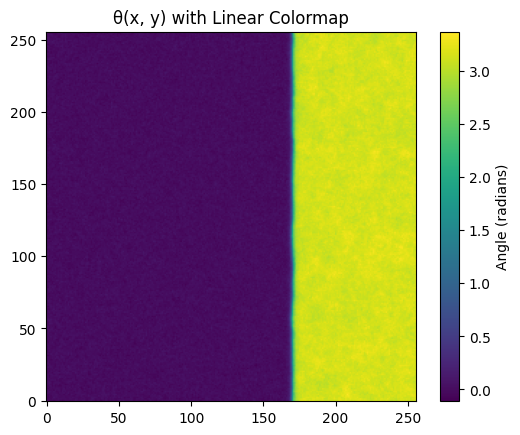

In [68]:
import numpy as np
import matplotlib.pyplot as plt

theta = np.loadtxt("theta_3000.csv", delimiter=" ")

plt.imshow(theta, cmap='viridis', origin='lower')
plt.colorbar(label='Angle (radians)')
plt.title("θ(x, y) with Linear Colormap")
plt.show()


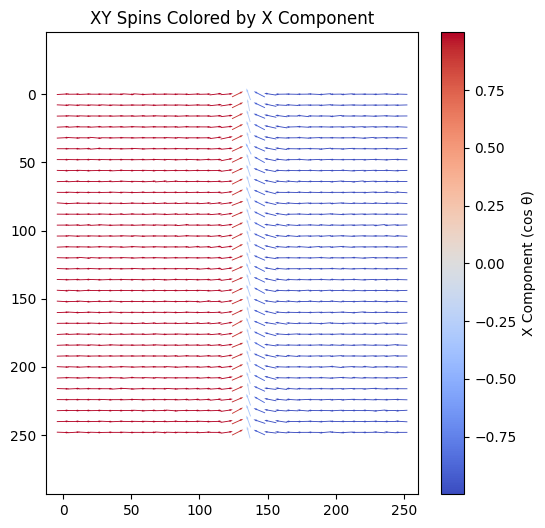

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Load θ(x, y)
theta = np.loadtxt("theta_100.csv", delimiter=" ")

# Compute spin vectors
U = np.cos(theta)  # x-component
V = np.sin(theta)  # y-component

# Set up grid (assumes square NxN)
N = theta.shape[0]
X, Y = np.meshgrid(np.arange(N), np.arange(N))

# Optional: downsample for visibility
step = max(N // 32, 1)
X_ = X[::step, ::step]
Y_ = Y[::step, ::step]
U_ = U[::step, ::step]
V_ = V[::step, ::step]

# Plot
plt.figure(figsize=(6, 6))
quiv = plt.quiver(X_, Y_, U_, V_, U_, pivot="middle", scale=30, headwidth=2, headlength=3, cmap="coolwarm")
plt.gca().invert_yaxis()
plt.axis("equal")
plt.title("XY Spins Colored by X Component")

# Add colorbar to interpret color mapping
plt.colorbar(quiv, label="X Component (cos θ)")
plt.show()


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import os

def plot_theta(file_number):
    filename = f"theta_{file_number:03d}.csv"
    if not os.path.isfile(filename):
        print(f"File not found: {filename}")
        return

    theta = np.loadtxt(filename, delimiter=" ")
    N = theta.shape[0]
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    U = np.cos(theta)
    V = np.sin(theta)

    step = max(N // 32, 1)
    X_ = X[::step, ::step]
    Y_ = Y[::step, ::step]
    U_ = U[::step, ::step]
    V_ = V[::step, ::step]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Left plot: quiver with color according to U_ (x-component)
    q = axes[0].quiver(X_, Y_, U_, V_, U_, pivot="middle", scale=30, cmap="coolwarm")
    axes[0].invert_yaxis()
    axes[0].axis("equal")
    axes[0].set_title(f"XY Spins from {filename}")
    fig.colorbar(q, ax=axes[0], label="X Component (cos θ)")

    # Right plot: theta field
    im = axes[1].imshow(theta, cmap='viridis', origin='lower')
    axes[1].set_title("θ(x, y) with Linear Colormap")
    fig.colorbar(im, ax=axes[1], label='Angle (radians)')

    plt.tight_layout()
    plt.show()

# Create the slider using ipywidgets
interact(plot_theta, file_number=IntSlider(min=100, max=10000, step=100, value=100));


interactive(children=(IntSlider(value=100, description='file_number', max=10000, min=100, step=100), Output())…

# Montecarlo

El ejemplo resuelve el modelo de Ising con el metodo de metropolis MonteCarlo. Es decir, genera una cadena de Markov que samplea configuraciones
$\{S_1,...,S_N\}$ con energías

$$H = - \sum_{<ij>} S_i S_j$$

donde $\sum_{<ij>}$ denota suma sobre pares de primeros vecinos,
y $S_i=\pm 1$ el "spin". El método de Monte Carlo garantiza
que para un número de "updates" lo suficientemente grande,
las configuraciones son sampleadas según su peso de Boltzmann

$$P\sim \exp[-H/k_B T]$$

permitiendo hacer promedios termodinámicos de equilibrio. En particular, la magnetización por sitio en función de la temperatura

$$M = \sum_i S_i/N$$

con $N=L \times L$ el numero total de sitios en una
red cuadrada de lado $L$.

La estrategia de paralelización es la del tablero de ajedrez: hacemos updates paralelos, de todas las fichas blancas primero, seguido por el de todas las negras, para evitar condiciones de carrera. Se puede demostrar que esta cadena de Markov converge a equilibrio térmico.

Referencias
* [GPU accelerated Monte Carlo simulations of lattice spin models](https://www.sciencedirect.com/science/article/pii/S1875389211003373)
* [A Performance Study of the 2D Ising Model on GPUs
](https://arxiv.org/abs/1906.06297)
* [Repo con ejemplo parecido, pero sin usar Thrust, solo CUDA C/C++. Incluye versión python](https://github.com/NVIDIA/ising-gpu/tree/master)

In [ ]:
#@title timers y macros
%%writefile timers.h

// cronometro para procesos en CPU
// USO: cpu_timer T; T.tic();...calculo...;T.tac(); cout << T.ms_elapsed << "ms\n";

#pragma once

#include <ctime>

struct timespec diff(timespec start, timespec end)
{
        timespec temp;
       	if ((end.tv_nsec-start.tv_nsec)<0) {
                temp.tv_sec = end.tv_sec-start.tv_sec-1;
                temp.tv_nsec = 1000000000+end.tv_nsec-start.tv_nsec;
        } else {
                temp.tv_sec = end.tv_sec-start.tv_sec;
                temp.tv_nsec = end.tv_nsec-start.tv_nsec;
        }
        return temp;
}

struct cpu_timer{
        struct timespec time1, time2;
	double ms_elapsed;

        cpu_timer(){
        	tic();
        }
       ~cpu_timer(){}

        void tic(){
                clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &time1);
        }
        double tac(){
                clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &time2);
                return(ms_elapsed=elapsed());
        }
        double elapsed(){
            return (double)diff(time1,time2).tv_sec*1000 + (double)diff(time1,time2).tv_nsec*0.000001;
        }
};

#define CRONOMETRAR_CPU( X,VECES ) {  { \
                            cpu_timer t; \
			    float msacum=0.0;\
			    float msacum2=0.0;\
			    for(int n=0;n<VECES;n++){\
			    	t.tic();\
                            	X; t.tac();\
				msacum+=t.ms_elapsed;\
				msacum2+=(t.ms_elapsed*t.ms_elapsed);\
			    }\
			    std::cout << "CPU: " << (msacum/VECES) << " +- " << \
			    (sqrt(msacum2/VECES - msacum*msacum/VECES/VECES)) \
			    << " ms (" << VECES << " veces)\n"; \
                            }}


// cronometro para procesos en GPU
// USO: gpu_timer T; T.tic();...calculo...;T.tac(); cout << T.ms_elapsed << "ms\n";

#pragma once
#ifdef __CUDACC__

///////////////////////////////// GPU TIMER ////////////////////////////////
// use CUDA's high-resolution timers when possible
/*
#include <cuda_runtime_api.h>
#include <thrust/system/cuda/error.h> //previous thrust releases
#include <thrust/system_error.h>
#include <string>
void HANDLE_ERROR(cudaError_t error, const std::string& message = "")
{
  if(error)
    throw thrust::system_error(error, thrust::cuda_category(), message);
}
*/

/*
 *
 *      From CUDA By Example An Introduction to General-Purpose GPU Programming”
 *  by Jason Sanders and Edward Kandrot, Addison-Wesley, Upper Saddle River, NJ, 2011
 *
 */

// Macro for handle errors
#include<stdio.h>
__host__ static void HandleError(cudaError_t err, const char *file, int line)
{
    if (err != cudaSuccess) {
        printf("%s in %s at line %d\n", cudaGetErrorString(err), file, line);
        exit(EXIT_FAILURE);
    }
}
#define HANDLE_NULL( a ) {if (a == NULL) { \
                            printf( "Host memory failed in %s at line %d\n", \
                                    __FILE__, __LINE__ ); \
                            exit( EXIT_FAILURE );}}
#define HANDLE_ERROR( err ) (HandleError( err, __FILE__, __LINE__ ))



/* Function to check for CUDA runtime errors */
static void checkCUDAError(const char* msg) {
	/* Get last error */
    cudaError_t err = cudaGetLastError();
    if( cudaSuccess != err) {
    	/* Print the error */
        printf("Cuda error: %s %s\n",msg, cudaGetErrorString( err));
        /* Abort the program */
        exit(EXIT_FAILURE);
    }
}


struct gpu_timer
{
  cudaEvent_t start;
  cudaEvent_t end;
  float ms_elapsed;

  gpu_timer(void)
  {
    HANDLE_ERROR(cudaEventCreate(&start));
    HANDLE_ERROR(cudaEventCreate(&end));
    tic();
  }

  ~gpu_timer(void)
  {
    HANDLE_ERROR(cudaEventDestroy(start));
    HANDLE_ERROR(cudaEventDestroy(end));
  }

  void tic(void)
  {
    HANDLE_ERROR(cudaEventRecord(start, 0));
  }

  double tac(void)
  {
    HANDLE_ERROR(cudaEventRecord(end, 0));
    HANDLE_ERROR(cudaEventSynchronize(end));

    HANDLE_ERROR(cudaEventElapsedTime(&ms_elapsed, start, end));
    return ms_elapsed;
  }

  double epsilon(void)
  {
    return 0.5e-6;
  }
};

#include<iostream>
#define CRONOMETRAR_GPU( X,VECES ) \
			    {  { \
                            gpu_timer t; \
			    float msacum=0.0;\
			    for(int n=0;n<VECES;n++){\
			    	t.tic();\
                            	X; t.tac();\
				msacum+=t.ms_elapsed;\
			    }\
			    std::cout << "GPU: " << (msacum) << \
			    " ms (" << VECES << " veces)\n"; \
                            }}

#endif


Writing timers.h


In [ ]:
#@title Modelo XY2d
%%writefile miniXY2d.cu

#include<iostream> //input-output pantalla
#include<fstream> //input-output disco
#include<cstdlib> // atoi, atof, etc
#include <unistd.h> // getop
#include <cmath>
#include <string>

//#include "gpu_timer.h"
//#include "cpu_timer.h"
#include "timers.h"

// thrust
#include<thrust/host_vector.h>
#include<thrust/device_vector.h>
#include <thrust/tuple.h>
#include <thrust/transform.h>
#include <thrust/functional.h>
#include <thrust/execution_policy.h>
#include<thrust/iterator/counting_iterator.h>

// definir RANDOM123 para usar en vez de curand
#ifndef RANDOM123

/* counter-based random numbers in curand API */
#include <curand_kernel.h>

#else

/* counter-based random numbers */
// http://www.thesalmons.org/john/random123/releases/1.06/docs/
#include <Random123/philox.h> // philox headers
#include <Random123/uniform.hpp>    // to get uniform deviates [0,1]
typedef r123::Philox4x32 RNG; // particular counter-based RNG

#endif


#define ANISO	0.2


// functor para obtener numeros aleatorios uniformes en [0,1]
// a partir de un key (sitio), un global seed, y un tiempo

#ifndef RANDOM123

__device__
float uniform(int n, int seed, int t)
{
    curandStatePhilox4_32_10_t s;

    // seed a random number generator
    curand_init(seed,n, t, &s);

    float x = curand_uniform(&s);

    return x;
}

#else

__device__
float uniform(int n, int seed, int t)
{
		// keys and counters
		RNG philox;
		RNG::ctr_type c={{}};
		RNG::key_type k={{}};
		RNG::ctr_type r;
		// Garantiza una secuencia random "unica" para cada thread
		k[0]=n;    // distintos sitios, distintos numeros random!
		c[1]=seed; // seed global, necesario para decidir reproducir secuencia, o no...
		c[0]=t;    // el seed tiene que cambiar con la iteracion, sino...
		r = philox(c, k); // son dos numeros random, usaremos uno solo r[0]

		return (r123::u01<float>(r[0])); // funcion adaptadora a [0,1]
}

#endif

// functor tipo predicado: cada thread determina si su sitio es del "color" 0 o 1
// necesario para "transform_if"
struct ficha
{
	bool color;
	int L;
	ficha(bool _color, int _L):color(_color),L(_L){};

	__device__ __host__
	bool operator()(int n){
		return ((n%L+int(n/L))%2==color); // true si n es color
	}
};

// functor: cada thread hace el metropolis update de su sitio
// ejemplo para modelo de Ising con interaccion de primeros vecinos
struct metropolis
{
	int L;
	float T;
	float *Mptr;
	int t;
	int seed;
	metropolis(float * _Mptr, float _T, int _L, int _t, int _seed):
	Mptr(_Mptr),T(_T),L(_L),t(_t),seed(_seed){};

	__device__
	float operator()(int n){

		int nx=n%L;
	  int ny=int(n/L);

		float local_field_x =
		cosf(Mptr[(nx-1+L)%L  + ny*L]) + cosf(Mptr[(nx+1+L)%L  + ny*L]) +
		cosf(Mptr[nx+((ny+1+L)%L)*L])  + cosf(Mptr[nx+((ny-1+L)%L)*L]);

		float local_field_y =
		sinf(Mptr[(nx-1+L)%L  + ny*L]) + sinf(Mptr[(nx+1+L)%L  + ny*L]) +
		sinf(Mptr[nx+((ny+1+L)%L)*L])  + sinf(Mptr[nx+((ny-1+L)%L)*L]);

		// contribucion de nuestro spin sin flipear a la energia
		float ene0=-cosf(Mptr[n])*local_field_x-sinf(Mptr[n])*local_field_y;

		// anisotropy
		ene0 += -ANISO*cosf(Mptr[n])*cosf(Mptr[n]);

		// change proposed
		float dang = 2.0*(uniform(n, seed, t)-0.5)*0.25;

		// contribucion a la energia de nuestro spin flipeado
		float ene1=-cosf(Mptr[n]+dang)*local_field_x-sinf(Mptr[n]+dang)*local_field_y;

		// anisotropy
		ene1 += -ANISO*cosf(Mptr[n]+dang)*cosf(Mptr[n]+dang);

		// metropolis: aceptar flipeo solo si r < exp(-(ene1-ene0)/temp)
		float p=exp(-(ene1-ene0)/T);

		// numero random entre [0,1] uniforme
		float rn = uniform(n, seed+1, t);

		// metropolis update segun regla de acceptancia
		return (rn<p)?(Mptr[n]+dang):(Mptr[n]);
	}
};

// imprime toda la red de sitios en pantalla
void print_campo_de_magnetizacion(thrust::device_vector<float> &M, int L, int nt)
{
	std::ofstream fout;
	std::string filename = "movie";
	std::string s = std::to_string(nt);
	std::string s2 = ".dat";
	filename = filename + s + s2;
	fout.open(filename);

	for(int ny=0;ny<L;ny++){
		for(int nx=0;nx<L;nx++){
			fout << M[nx+ny*L] << " ";
		}
		fout << std::endl;
	}
	fout.close();
}

/*
COMPILACION:
nvcc miniising.cu
*/
int main(int argc, char **argv)
{
	int globalseed=123456; // semilla global generador paralelo
	int L=512; // largo red cuadrada
	float T=1.0; // temperatura
	int nrun=1000; // numero total de pasos de MonteCarlo
	int tsnap=nrun+1; // cada cuando imprimo configs
	std::ofstream mout("mag.dat"); // fichero para guardar magnetizacion por sitio vs tiempo

	// para tomar opciones de la linea de comandos
	int opt;
	while ((opt = getopt(argc, argv, "l:r:T:s:w:")) != -1)
	{
               switch (opt) {
               case 'l':
                   L = atoi(optarg);
                   break;
               case 'r':
                   nrun = atoi(optarg);
                   break;
               case 'T':
                   T = atof(optarg);
                   break;
               case 's':
                   globalseed = atoi(optarg);
                   break;
               case 'w':
                   tsnap = atoi(optarg);
                   break;
               default: /* '?' */
                   fprintf(stderr, "Uso: %s [-l L] [-r niter] [-T temp] [-s semilla] [-w snap]\n", argv[0]);
                   exit(EXIT_FAILURE);
               }
	}

	std::ofstream logout("log.dat"); // fichero para guardar configs
	logout << "L=" << L << ", ";
	logout << "nrun=" << nrun << ", ";
	logout << "T=" << T << ", ";
	logout << "globalseed= " << globalseed << " ";
	logout << "tsnap= " << tsnap << "\n";
	std::cout << "L=" << L << ", ";
	std::cout << "nrun=" << nrun << ", ";
	std::cout << "T=" << T << ", ";
	std::cout << "globalseed= " << globalseed << " ";
	std::cout << "tsnap= " << tsnap << "\n";

#ifdef __CUDACC__
  int card;
  cudaGetDevice(&card);
  cudaDeviceProp deviceProp;
  cudaGetDeviceProperties(&deviceProp, card);
  logout << "\nDevice Selected " << card << " " << deviceProp.name << "\n";
	std::cout << "\nDevice Selected " << card << " " << deviceProp.name << "\n";
#else
	std::cout << "\nrun in CPU " << "\n";
#endif

	/**************************************************/
	// AHORA EMPIEZA LO IMPORTANTE


	if(L%2==1) std::cout << "warning: para usar checkerboard L debe ser par" << std::endl;

	int N=L*L;

	// angulo del vector de magnetizacion en la red
	thrust::device_vector<float> M(N,-1);
	float *Mraw=thrust::raw_pointer_cast(M.data()); // puntero crudo

	// condicion inicial random, usando generador standard de C
	for(int n=0;n<N;n++) {
		//int i=n/L;
		//int j=n%L;
		M[n]=(rand()*0.0/RAND_MAX)*2*M_PI;
	}

	cpu_timer crono;
	crono.tic();

	// loop de pasos de MonteCarlo
	for(int nt=0;nt<nrun;nt++)
	{
		//ojo!: lento, GPU->CPU->disco de mucha info! (hacer cada muchos pasos)
		if(nt%tsnap==0) {
				print_campo_de_magnetizacion(M, L, nt);
				std::cout << nt*100./nrun << "% ";
		}
		// imprime magnetizacion por sitio (usando parallel reduction)
		mout << nt << " " << thrust::reduce(M.begin(),M.end())*1.0/N << std::endl;

		for(int color=0;color<2;color++){ // "checkerboard decomposition"
			// update de sitios de color "color" usando transform_if paralelo
			thrust::transform_if(
				thrust::make_counting_iterator(0), thrust::make_counting_iterator(N), //rango
				M.begin(), // output
				metropolis(Mraw,T,L,nt,globalseed), // operacion
				ficha(color, L) // predicado
			);
		}
	}

	std::cout << "ejecutable = " << argv[0] << std::endl;
	std::cout << "ms = " << crono.tac() << std::endl;


	logout << "ejecutable = " << argv[0] << std::endl;
	logout << "tiempo de ejecución [ms] = " << crono.tac() << std::endl;


	return 0;
}




Overwriting miniXY2d.cu


In [ ]:
!nvcc -arch=sm_75 miniXY2d.cu -o miniXY2d -arch=sm_75

Corrida con parámetros de la línea de comandos

* -l tamaño
* -r número_total_de_pasos_de_MC
* -T temperatura
* -s semilla_aleatorios
* -w cada_cuanto_graba_configuración

Para medir performance poner parámetro de "-w" de tal forma de que no imprima ninguna configuración durante la corrida: "número_total_de_pasos_de_MC < cada_cuanto_graba_configuración".

In [ ]:
!rm movie*.dat

rm: cannot remove 'movie*.dat': No such file or directory


In [ ]:
!./miniXY2d -l 128 -r 1000 -T 0.001 -s 123456 -w 100

L=128, nrun=1000, T=0.001, globalseed= 123456 tsnap= 100

Device Selected 0 Tesla T4
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% ejecutable = ./miniXY2d
ms = 1688.71


In [ ]:
!awk 'END{print NF, NR}' /content/movie100.dat

128 128


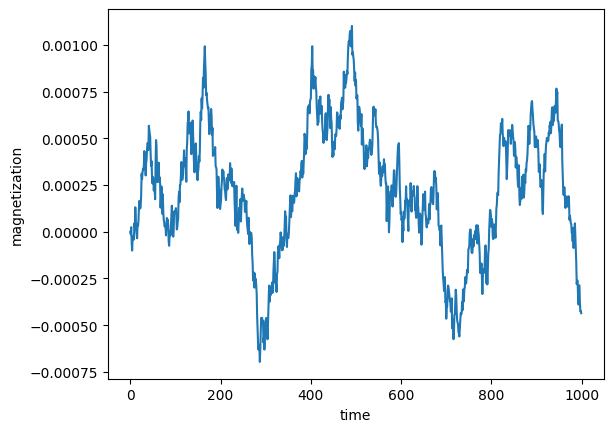

In [ ]:
# prompt: plot the file "mag.dat" with xlabel='time' and ylabel='magnetization
# '

import numpy as np
import matplotlib.pyplot as plt

def plot_magnetization():
  # Load the data from the file
  data = np.loadtxt('mag.dat')

  # Extract the time and magnetization columns
  time = data[:, 0]
  magnetization = data[:, 1]

  # Plot the data
  plt.plot(time, magnetization)

  # Set the labels
  plt.xlabel('time')
  plt.ylabel('magnetization')

  # Show the plot
  plt.show()

plot_magnetization()

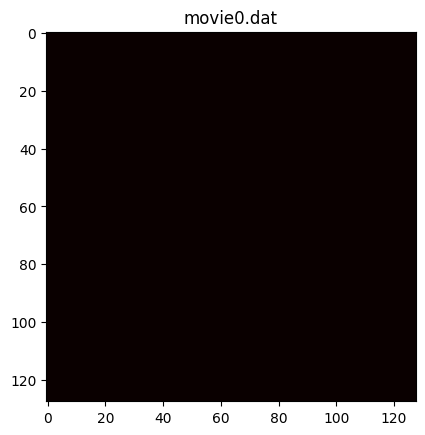

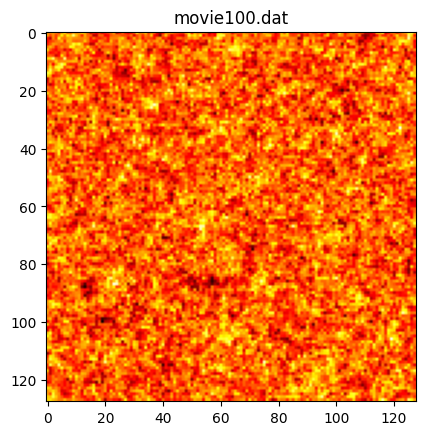

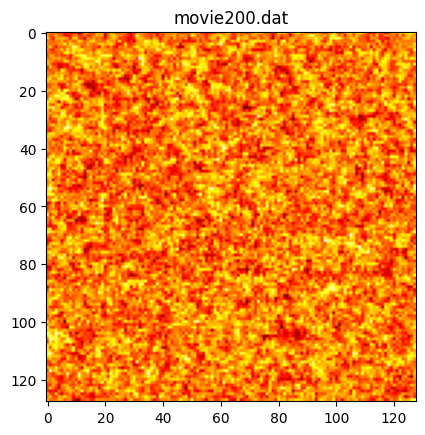

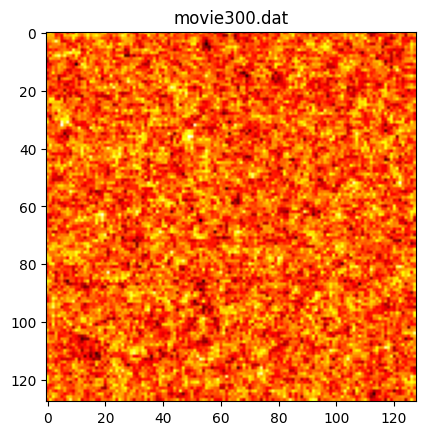

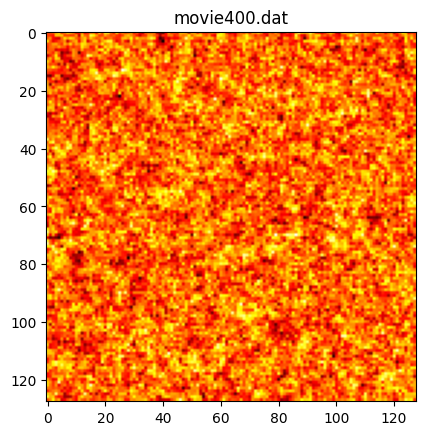

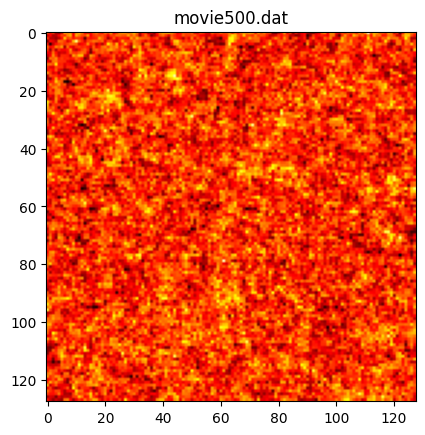

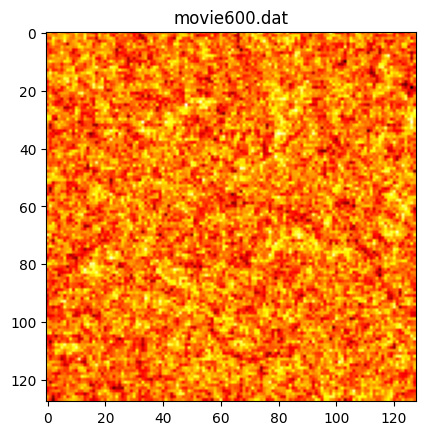

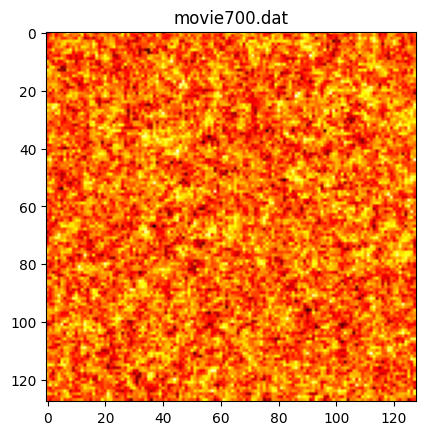

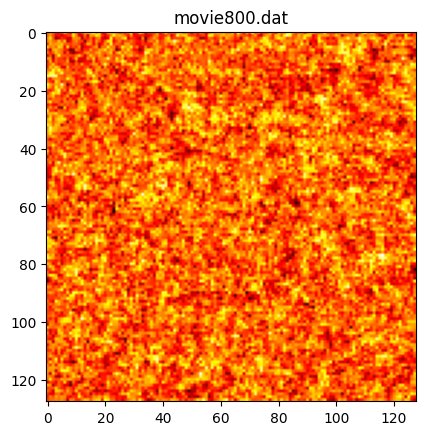

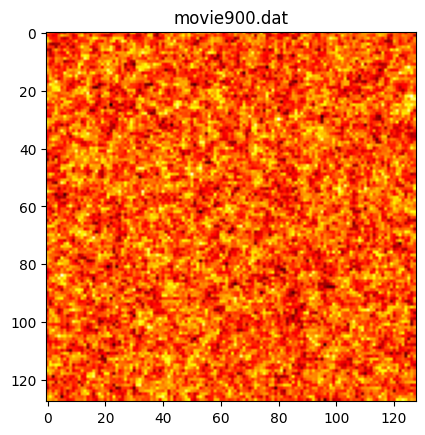

In [ ]:
# prompt: Plot all files named movie0.dat, movie100.dat movie200.dat, etc, up to movie900.dat as heat maps and put the filename as titles.

import matplotlib.pyplot as plt
import numpy as np

def plot_movie():
  # Define the range of files to load
  file_range = range(0, 1000, 100)

  # Loop through the files and plot them
  for i in file_range:
      # Load the data from the file
      data = np.loadtxt(f'movie{i}.dat')

      # Create the heat map
      plt.imshow(data, cmap='hot')

      # Set the title
      plt.title(f'movie{i}.dat')

      # Show the plot
      plt.show()

plot_movie()

# Version usando RANDOM123 directamente

La ventaja que tiene es que es portable, a diferencia de la que usa curand que presupone que uno corre en gpu.

In [ ]:
#@title Si no queremos usar curand, y usar un buen generador portable CPU/GPU
!git clone https://github.com/DEShawResearch/random123.git

Cloning into 'random123'...
remote: Enumerating objects: 2422, done.
remote: Counting objects: 100% (2422/2422), done.
remote: Compressing objects: 100% (374/374), done.
remote: Total 2422 (delta 2070), reused 2342 (delta 1992), pack-reused 0 (from 0)
Receiving objects: 100% (2422/2422), 1.98 MiB | 5.04 MiB/s, done.
Resolving deltas: 100% (2070/2070), done.


In [ ]:
!nvcc -arch=sm_75 miniIsing.cu -o miniIsing -DRANDOM123 -I/content/random123/include

In [ ]:
!./miniIsing -l 512 -r 1000 -T 2.0 -s 123456 -w 100

L=512, nrun=1000, T=2, globalseed= 123456 tsnap= 100

Device Selected 0 Tesla T4
ejecutable = ./miniIsing
ms = 25532.7


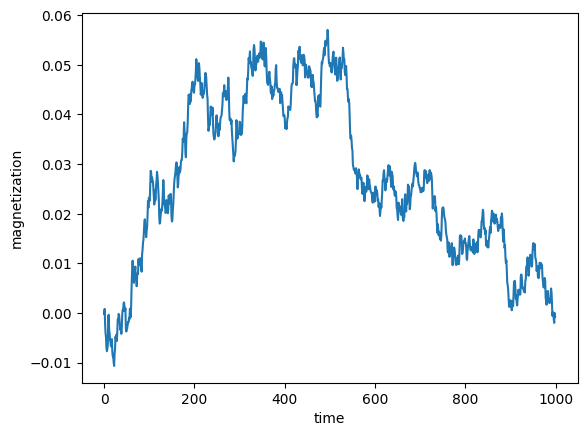

In [ ]:
plot_magnetization()

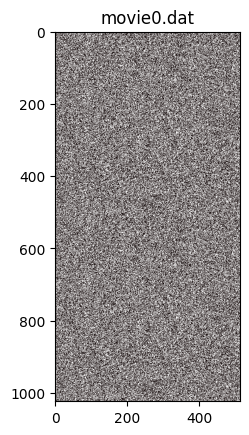

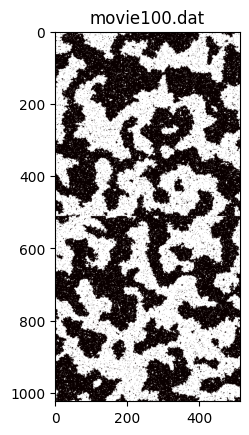

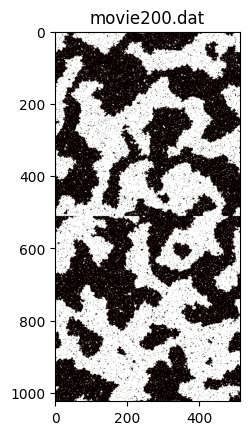

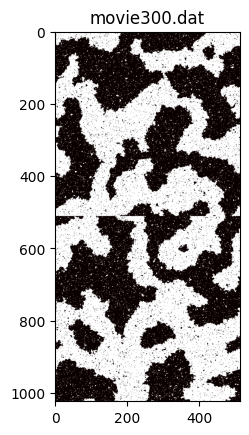

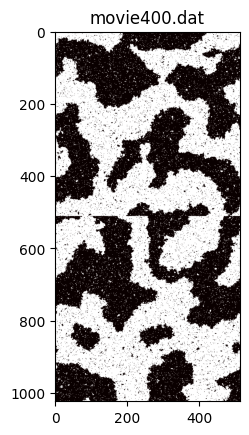

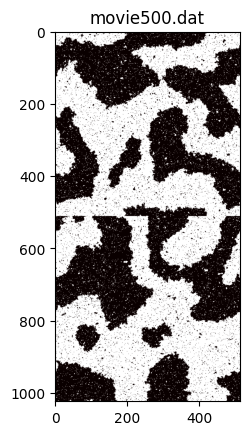

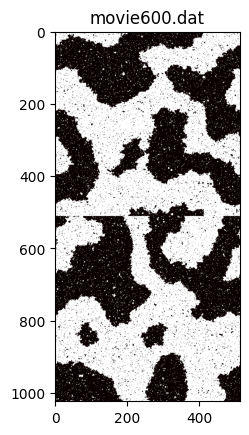

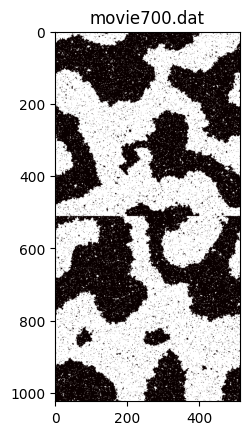

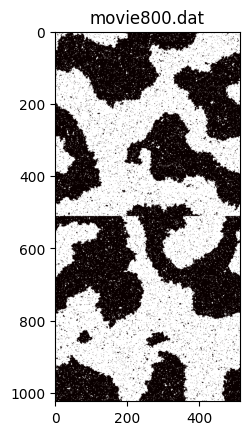

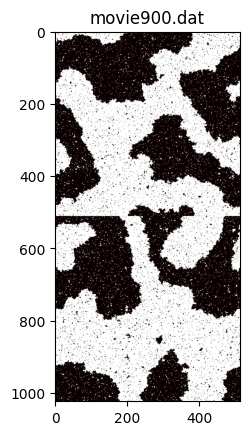

In [ ]:
plot_movie()

# Compilando para GPU o CPU

## CPU

In [ ]:
!cp miniIsing.cu miniIsing.cpp; g++ -O2 miniIsing.cpp -DTHRUST_DEVICE_SYSTEM=THRUST_DEVICE_SYSTEM_CPP -I/usr/local/cuda/include/ -o miniIsingCPU

In [ ]:
!./miniIsingCPU -l 512 -r 1000 -T 2.0 -s 123456 -w 1001

L=512, nrun=1000, T=2, globalseed= 123456 tsnap= 1001

run in CPU 
ejecutable = ./miniIsingCPU
ms = 14036.1


## CPU multicore (openMP)

In [ ]:
!cp miniIsing.cu miniIsing.cpp; g++ -O2 miniIsing.cpp -fopenmp -DTHRUST_DEVICE_SYSTEM=THRUST_DEVICE_SYSTEM_OMP -lgomp -I/usr/local/cuda/include/ -o miniIsingCPUparalelo

In [ ]:
!./miniIsingCPUparalelo -l 512 -r 1000 -T 2.0 -s 123456 -w 1001

L=512, nrun=1000, T=2, globalseed= 123456 tsnap= 1001

run in CPU 
ejecutable = ./miniIsingCPUparalelo
ms = 21831.2


## GPU

In [ ]:
!nvcc miniIsing.cu -o miniIsingR123  -I/content/random123/include

In [ ]:
!./miniIsingR123 -l 512 -r 1000 -T 2.0 -s 123456 -w 1001

L=512, nrun=1000, T=2, globalseed= 123456 tsnap= 1001

Device Selected 0 Tesla T4
ejecutable = ./miniIsingR123
ms = 2637.58


In [ ]:
!nvcc miniIsing.cu -o miniIsing

In [ ]:
!./miniIsing -l 512 -r 1000 -T 2.0 -s 123456 -w 1001

L=512, nrun=1000, T=2, globalseed= 123456 tsnap= 1001

Device Selected 0 Tesla T4
ejecutable = ./miniIsing
ms = 2473.7


# Random123 y curand philox

In [ ]:
%%writefile testcurand.cu

#include <stdio.h>
#include <curand_kernel.h>

__global__ void generate_random(unsigned int *output) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;

    // Initialize cuRAND Philox RNG
    curandStatePhilox4_32_10_t state;
    curand_init(12345, 0, 0, &state);  // (Seed = 12345, Sequence = 0, Offset = 0)

    // Generate 4 random 32-bit integers
    uint4 r = curand_philox4x32_10(&state);

    output[4 * idx + 0] = r.x;
    output[4 * idx + 1] = r.y;
    output[4 * idx + 2] = r.z;
    output[4 * idx + 3] = r.w;
}

int main() {
    unsigned int *d_output, h_output[4];
    cudaMalloc(&d_output, 4 * sizeof(unsigned int));

    generate_random<<<1, 1>>>(d_output);
    cudaMemcpy(h_output, d_output, 4 * sizeof(unsigned int), cudaMemcpyDeviceToHost);

    printf("Random values: %u %u %u %u\n", h_output[0], h_output[1], h_output[2], h_output[3]);

    cudaFree(d_output);
    return 0;
}


Overwriting testcurand.cu


In [ ]:
!nvcc -arch=sm_75 testcurand.cu -o testcurand -lcurand

testcurand.cu(13): error: identifier "curand_philox4x32_10" is undefined
      uint4 r = curand_philox4x32_10(&state);
                ^

1 error detected in the compilation of "testcurand.cu".


In [ ]:
# prompt: testcurand.cu(13): error: identifier "curand_philox4x32" is undefined

#include <stdio.h>
#include <curand_kernel.h>

__global__ void generate_random(unsigned int *output) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;

    // Initialize cuRAND Philox RNG
    curandStatePhilox4_32_10_t state;
    curand_init(12345, 0, 0, &state);  // (Seed = 12345, Sequence = 0, Offset = 0)

    // Generate 4 random 32-bit integers
    uint4 r = curand_philox4x32_10(&state); // Use the correct function

    output[4 * idx + 0] = r.x;
    output[4 * idx + 1] = r.y;
    output[4 * idx + 2] = r.z;
    output[4 * idx + 3] = r.w;
}

int main() {
    unsigned int *d_output, h_output[4];
    cudaMalloc(&d_output, 4 * sizeof(unsigned int));

    generate_random<<<1, 1>>>(d_output);
    cudaMemcpy(h_output, d_output, 4 * sizeof(unsigned int), cudaMemcpyDeviceToHost);

    printf("Random values: %u %u %u %u\n", h_output[0], h_output[1], h_output[2], h_output[3]);

    cudaFree(d_output);
    return 0;
}